In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

import math
from typing import Optional

import torch

In [ ]:
# | export


def complex_oscillator(
    z: torch.ComplexType,
    initial_phase: Optional[torch.ComplexType] = None,
    N: int = 2048,
    constrain: bool = False,
    reduce: bool = False,
):
    """Generates an exponentially decaying sinusoid from a complex number."""

    if initial_phase is None:
        # If no initial phase is provided, use zero phase.
        # Note that in the complex representation, zero phase is equivalent to a real number.
        initial_phase = torch.ones_like(z)
    
    if constrain:
        # Limit the magnitude of z to 1. Note that tanh is used in lieu of sigmoid to 
        # avoid vanishing gradients as magnitude approaches zero.
        mag = torch.abs(z)
        z = z * torch.tanh(mag) / mag

    z = z[..., None].expand(*z.shape, N - 1)
    z = torch.cat([initial_phase.unsqueeze(-1), z], dim=-1)
    
    y = z.cumprod(dim=-1).real

    if reduce:
        y = y.sum(dim=-2)

    return y

In [ ]:
#| hide
import matplotlib.pyplot as plt

Using the above oscillator to generate a signal at the Nyquist frequency:

[<matplotlib.lines.Line2D>]

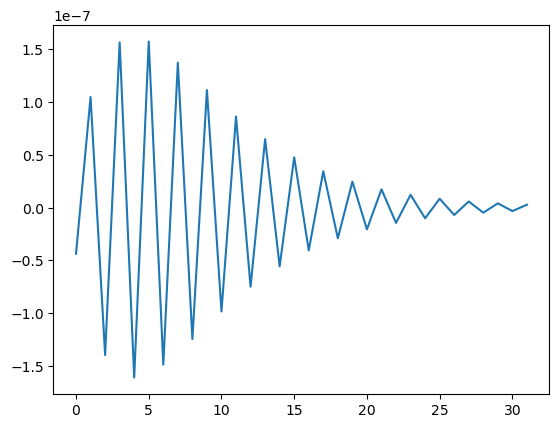

In [ ]:
freq = 0.5
amp = 0.8
initial_phase = 1.0 * torch.exp(torch.tensor([1j * math.pi / 2]))
N = 32
z = torch.polar(torch.tensor([amp]), torch.tensor([freq * 2 * math.pi]))
sig = complex_oscillator(z, initial_phase, N, reduce=True)


plt.plot(sig)

In [ ]:
#| export

def estimate_amplitude(z, N, constrain=False, representation="fft"):
    V = complex_oscillator(z, N=N, constrain=constrain).sum(dim=-2)

    n = torch.arange(N, device=z.device)
    omega = torch.angle(z)

    U = torch.cos(omega[..., None, :] * n[None, :, None])

    if representation == "fft":
        U = torch.fft.rfft(U, dim=-2).abs()
        V = torch.fft.rfft(V).abs()

    least_squares_soln = torch.linalg.lstsq(U, V).solution
    return least_squares_soln

In [ ]:
z = 0.99 * torch.exp(1j * torch.rand(2, 6))
N = 2048

estimate_amplitude(z, N, representation="lin")

tensor([[0.0525, 0.0681, 0.0640, 0.0530, 0.0635, 0.0679],
        [0.0522, 0.0522, 0.0522, 0.0517, 0.0528, 0.0648]])

In [ ]:
# | export


def get_reduce_fn(reduce: str):
    if reduce == "mean":
        return torch.mean
    elif reduce == "sum":
        return torch.sum
    elif reduce == "none":
        return lambda x: x
    else:
        raise ValueError(f"Invalid reduction method: {reduce}")


def fft_loss(
    pred_signal,
    target_signal,
    lin_l1: float = 1.0,
    lin_l2: float = 0.0,
    lin_huber: float = 0.0,
    log_l1: float = 0.0,
    log_l2: float = 0.0,
    log_huber: float = 0.0,
    reduce_freq: str = "mean",
    reduce_batch: str = "sum",
    eps: float = 1e-8,
):
    freq_reduce_fn = get_reduce_fn(reduce_freq)
    batch_reduce_fn = get_reduce_fn(reduce_batch)
    pred_fft = torch.fft.rfft(pred_signal, norm="ortho").abs()
    target_fft = torch.fft.rfft(target_signal, norm="ortho").abs()
    lin_l1 = (
        lin_l1 * torch.nn.functional.l1_loss(pred_fft, target_fft)
        if lin_l1 != 0.0
        else 0.0
    )
    lin_l2 = (
        lin_l2 * torch.nn.functional.mse_loss(pred_fft, target_fft)
        if lin_l2 != 0.0
        else 0.0
    )
    lin_huber = (
        lin_huber * torch.nn.functional.huber_loss(pred_fft, target_fft)
        if lin_huber != 0.0
        else 0.0
    )
    log_l1 = (
        log_l1
        * torch.nn.functional.l1_loss(
            torch.log(pred_fft + eps), torch.log(target_fft + eps)
        )
        if log_l1 != 0.0
        else 0.0
    )
    log_l2 = (
        log_l2
        * torch.nn.functional.mse_loss(
            torch.log(pred_fft + eps), torch.log(target_fft + eps)
        )
        if log_l2 != 0.0
        else 0.0
    )
    log_huber = (
        log_huber
        * torch.nn.functional.huber_loss(
            torch.log(pred_fft + eps), torch.log(target_fft + eps)
        )
        if log_huber != 0.0
        else 0.0
    )

    return lin_l1 + lin_l2 + lin_huber + log_l1 + log_l2 + log_huber

In [ ]:
#| export

def real_oscillator(freqs, amps, phases=None, N=2048):
    """Generate real sinusoids with given frequencies, amplitudes, and phases."""
    freqs = freqs[..., None]
    amps = amps[..., None]
    phases = phases[..., None] if phases is not None else torch.zeros_like(freqs)
    n = torch.arange(N, dtype=torch.float32, device=freqs.device)[..., None, :]
    return torch.cos(freqs * n + phases) * amps

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()